In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from problems.time_series.common import trend, seasonality, noise, windowed_dataset, plot_series, windowed_dataset_conv

tf.__version__

import typing
from tensorflow import keras

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras

In [2]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

Epoch 1/100
8/8 [==============================] - 3s 11ms/step - loss: 124.0134 - mae: 124.5132 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 123.1590 - mae: 123.6588 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 121.8832 - mae: 122.3829 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 120.3145 - mae: 120.8143 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 118.5071 - mae: 119.0069 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 116.5813 - mae: 117.0811 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 114.4803 - mae: 114.9801 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 112.1435 - mae: 112.6432 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 12ms/step - loss: 109.5933 - mae: 

(1e-08, 0.0001, 0.0, 30.0)

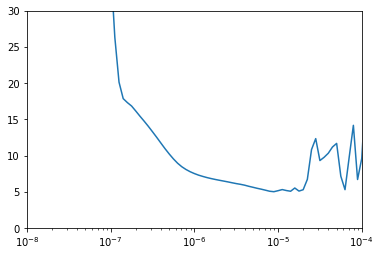

In [72]:
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)


def f(x):
    return tf.expand_dims(x, axis=-1)


model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(f),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [73]:
dataset = windowed_dataset_conv(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500)

Epoch 1/500
31/31 [==============================] - 2s 8ms/step - loss: 11.3850 - mae: 11.8729
Epoch 2/500
31/31 [==============================] - 0s 10ms/step - loss: 6.8302 - mae: 7.3122
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 5.9735 - mae: 6.4537
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 5.7000 - mae: 6.1790
Epoch 5/500
31/31 [==============================] - 0s 11ms/step - loss: 5.5566 - mae: 6.0361
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 5.4453 - mae: 5.9246
Epoch 7/500
31/31 [==============================] - 0s 11ms/step - loss: 5.3036 - mae: 5.7815
Epoch 8/500
31/31 [==============================] - 0s 10ms/step - loss: 5.3218 - mae: 5.8004
Epoch 9/500
31/31 [==============================] - 0s 5ms/step - loss: 5.3356 - mae: 5.8146
Epoch 10/500
31/31 [==============================] - 0s 5ms/step - loss: 5.2372 - mae: 5.7154
Epoch 11/500
31/31 [==============================] -

5.885613


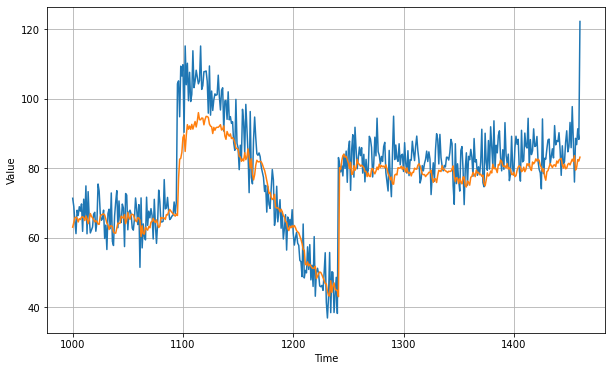

In [89]:
def model_forecast(model, series, window_size):
    ds = tf.expand_dims(series, axis=-1)  # !!!!!!!!
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

<Figure size 432x288 with 0 Axes>

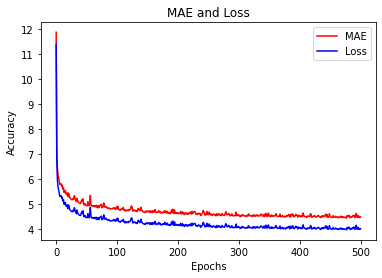

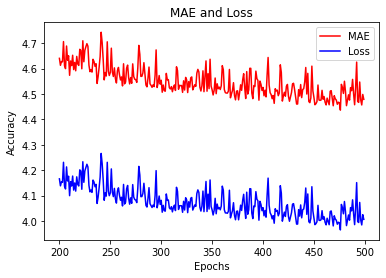

<Figure size 432x288 with 0 Axes>

In [84]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))  # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()